In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [59]:
def simulation(n, time_step, step_length, p_step_forward, p_fall_off):
    max_distances =[]
    for i in range(1, n+1):
        loc = 0.0 #current location of motor
        t = 0.0 #current time
        while True:
            t = t + time_step # update simulation time
            r1 = random.random() # generate a random number to decide whether step forward, drop off, or stay
            if r1 < p_step_forward:
                loc = loc + step_length
            elif r1 < (p_step_forward + p_fall_off):
                break
        max_distances.append(loc)
    return max_distances

In [60]:
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_dev = stats.sem(data)
    h = std_dev * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean-h, mean, mean+h

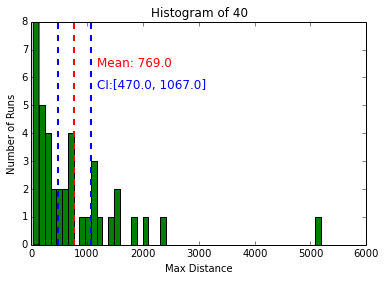

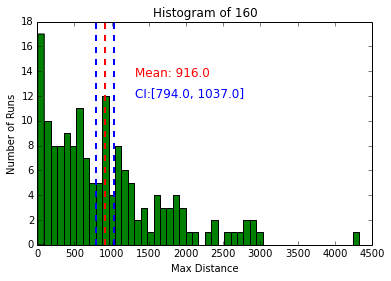

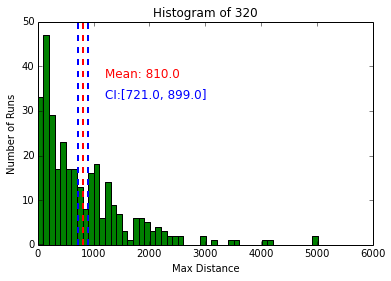

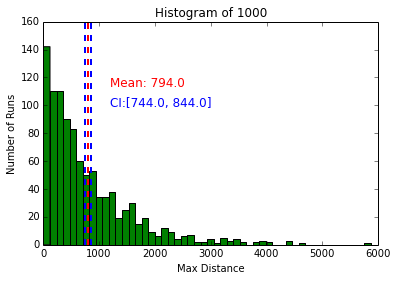

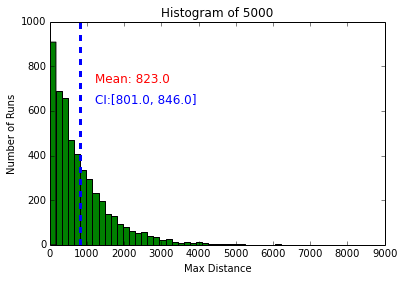

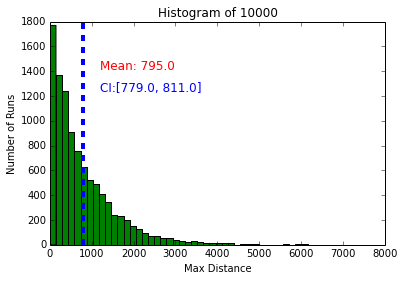

In [62]:
time_step = 1./10000
step_length = 8.
p_step_forward = 1./100
p_fall_off = 1./10000
for n in [40, 160, 320, 1000, 5000, 10000]:
    dists = np.array(simulation(n, time_step, step_length, p_step_forward, p_fall_off))
    lci, mean, rci = mean_confidence_interval(dists, confidence=0.95) # left and right confidence interval and mean
    hist = plt.hist(dists, bins = 50, color = 'g')
    plt.axvline(x=mean, color='r', linewidth=2, linestyle='dashed')
    plt.axvline(x=lci, color='b', linewidth=2, linestyle='dashed')
    plt.axvline(x=rci, color='b', linewidth=2, linestyle='dashed')
    plt.text(mean + 400., hist[0].max()*0.8, 'Mean: '+ str(round(mean)), fontsize=12, color = 'r')
    plt.text(mean + 400., hist[0].max()*0.7, 'CI:[' + str(round(lci)) + ", "+ str(round(rci)) + "]", fontsize=12, color = 'b')
    plt.title("Histogram of " + str(n))
    plt.xlabel("Max Distance")
    plt.ylabel("Number of Runs")
    plt.show()

In [63]:
def compute_proportion(CIs, mean= 800):
    n = len(CIs)
    nci_include_mean = 0.
    for i in range(n):
        lci, rci = CIs[i]
        if lci <= mean <= rci:
            nci_include_mean = nci_include_mean + 1
    return nci_include_mean/n
            

In [64]:
ntrials = 2
sample_sz = 10000
CIs = []
for i in range(ntrials):
    dists = np.array(simulation(sample_sz, time_step, step_length, p_step_forward, p_fall_off))
    lci, _, rci = mean_confidence_interval(dists, confidence=0.95) # left and right confidence interval and mean
    CIs.append([lci, rci])
print compute_proportion(CIs)

1.0
